# Textual Sentiment: EDA

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns 
import time
from scipy.stats import norm
sns.set()
# Standard plotly imports
import plotly
# Authenticate with your account
plotly.tools.set_credentials_file(username='Abcde54321',                                              
                                  api_key='hcooLngkiMrN7qXHBs5s')
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [9]:
BTC = pd.read_csv('BTC_merged.txt', sep = ',')
List_BTC = []
for i in range(len(BTC)):
    List_BTC.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(BTC['time'][i])))
BTC['datetime'] = pd.DataFrame(List_BTC)
BTC['datetime'] = pd.to_datetime(BTC['datetime'])
BTC = BTC.set_index('datetime')

In [10]:
BTC_sentiment = BTC[['positive_score_en', 'negative_score_en',
       'score_en', 'positive_volume_en', 'negative_volume_en',
       'volume_ratio_en', 'total_volume_en', 'total_volume_non_en',
       'total_volume_global']]

In [11]:
BTC_sentiment['neutral_volume_en'] = BTC_sentiment['total_volume_en'] - BTC_sentiment['positive_volume_en'] - BTC_sentiment['negative_volume_en']

In [12]:
BTC_sentiment.head()

,positive_score_en,negative_score_en,score_en,positive_volume_en,negative_volume_en,volume_ratio_en,total_volume_en,total_volume_non_en,total_volume_global,neutral_volume_en
datetime,,,,,,,,,,
2014-09-01 01:00:00,1.782259,2.126567,-0.344307,37,24,1.5417,715,105,820,654
2014-09-01 02:00:00,1.670194,2.222970,-0.552776,33,23,1.4348,553,75,628,497
2014-09-01 03:00:00,1.623197,2.094666,-0.471468,36,29,1.2414,686,93,779,621
2014-09-01 04:00:00,1.647320,1.964704,-0.317384,45,23,1.9565,617,101,718,549
2014-09-01 05:00:00,1.669959,1.945795,-0.275836,34,21,1.6190,579,116,695,524


## Volume

In [21]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20,8

Text(0.5, 1.0, 'Volume Ratios')

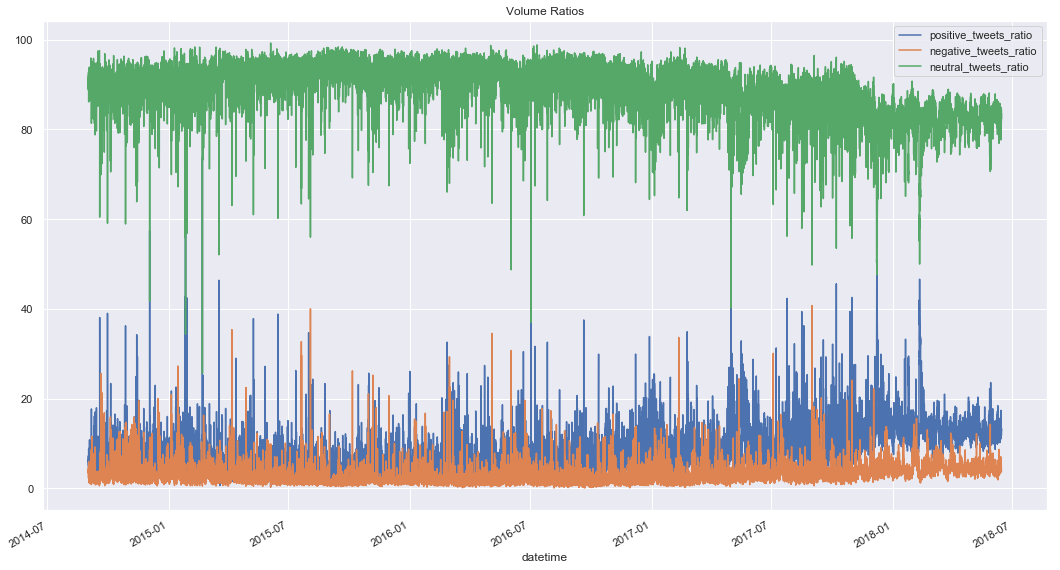

In [14]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 18,10

BTC_sentiment['positive_tweets_ratio'] = 100*BTC_sentiment['positive_volume_en']/BTC_sentiment['total_volume_en']
BTC_sentiment['negative_tweets_ratio'] = 100*BTC_sentiment['negative_volume_en']/BTC_sentiment['total_volume_en']
BTC_sentiment['neutral_tweets_ratio'] = 100*BTC_sentiment['neutral_volume_en']/BTC_sentiment['total_volume_en']
BTC_sentiment['positive_tweets_ratio'].plot()
BTC_sentiment['negative_tweets_ratio'].plot()
BTC_sentiment['neutral_tweets_ratio'].plot()
plt.legend()
plt.title('Volume Ratios')

## Average Score Strategy

- Strategy #1: Sentiment Following - I will buy as much stocks as I can when the sentiment is positive and sell all I have when the sentiment is negative.

- Strategy #2: Mean Reversion - I will do the opposite because as Warren Buffet said - "We simply attempt to be fearful when others are greedy and to be greedy only when others are fearful"

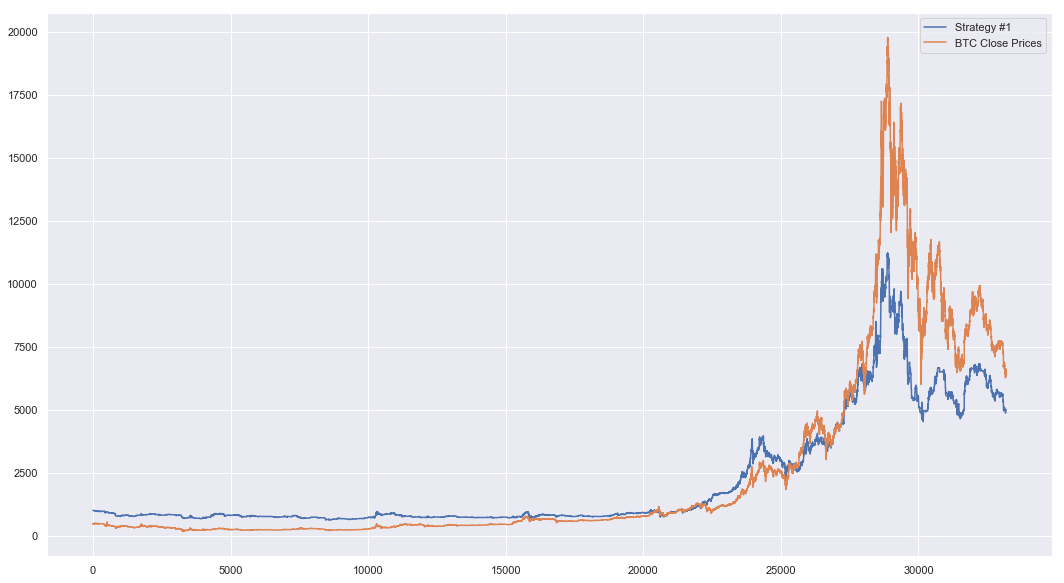

In [15]:
time_window = 1

prices = BTC['close'].values
sentiments = BTC_sentiment['score_en'].values

w = np.zeros(len(prices))
cash = np.zeros(len(prices))

cash[0] = 1000

for i in range(len(prices)-1):
    if sentiments[i] < 0:
        cash[i+1] = w[i]*prices[i] + cash[i]
        w[i+1] = 0
    if sentiments[i] > 0:
        w[i+1] = cash[i]/prices[i]  + w[i]
        cash[i+1] = 0
        
tf_strategy1 = [a*b for a,b in zip(w,prices)]+ cash
plt.plot(tf_strategy1, label = 'Strategy #1')
plt.plot(prices, label = 'BTC Close Prices')
plt.legend()

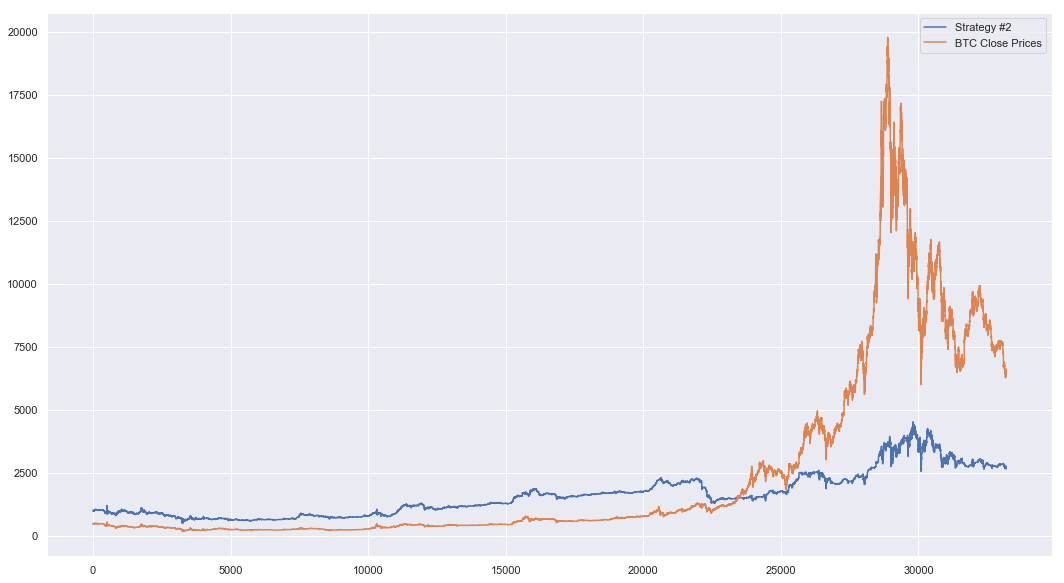

In [16]:
time_window = 1

prices = BTC['close'].values
sentiments = BTC_sentiment['score_en'].values

w = np.zeros(len(prices))
cash = np.zeros(len(prices))

cash[0] = 1000

for i in range(len(prices)-1):
    if sentiments[i] > 0:
        cash[i+1] = w[i]*prices[i] + cash[i]
        w[i+1] = 0
    if sentiments[i] < 0:
        w[i+1] = cash[i]/prices[i]  + w[i]
        cash[i+1] = 0
        
tf_strategy2 = [a*b for a,b in zip(w,prices)]+ cash
plt.plot(tf_strategy2, label = 'Strategy #2')
plt.plot(prices, label = 'BTC Close Prices')
plt.legend()

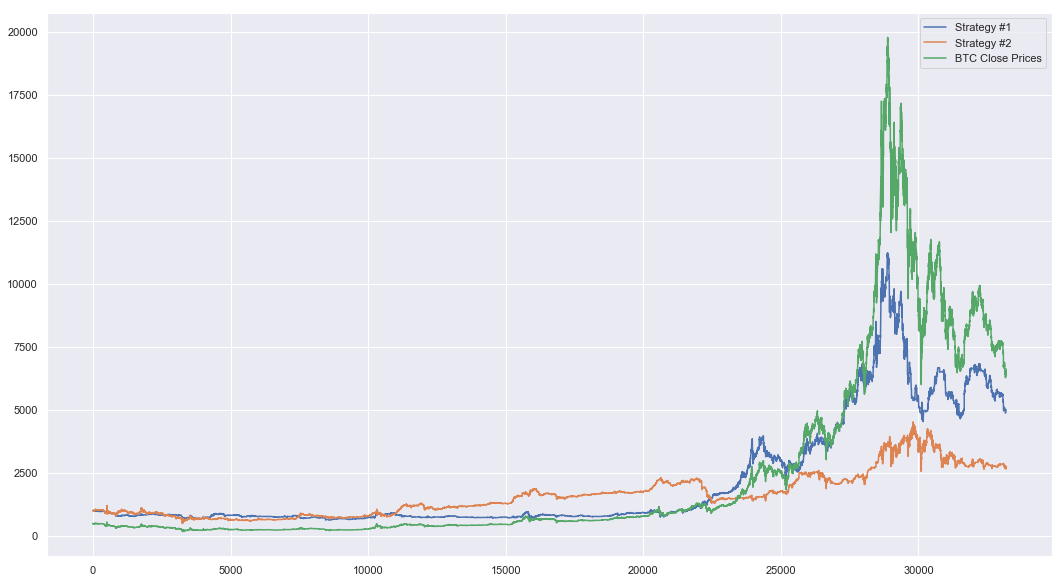

In [17]:
plt.plot(tf_strategy1, label = 'Strategy #1')
plt.plot(tf_strategy2, label = 'Strategy #2')
plt.plot(prices, label = 'BTC Close Prices')
plt.legend()

These strategies are not realistic because of the transaction costs associated to each transaction done each hour

### Change #2: Consider only high variations in sentiment, when it is between -0.5 and 0.5 do nothing

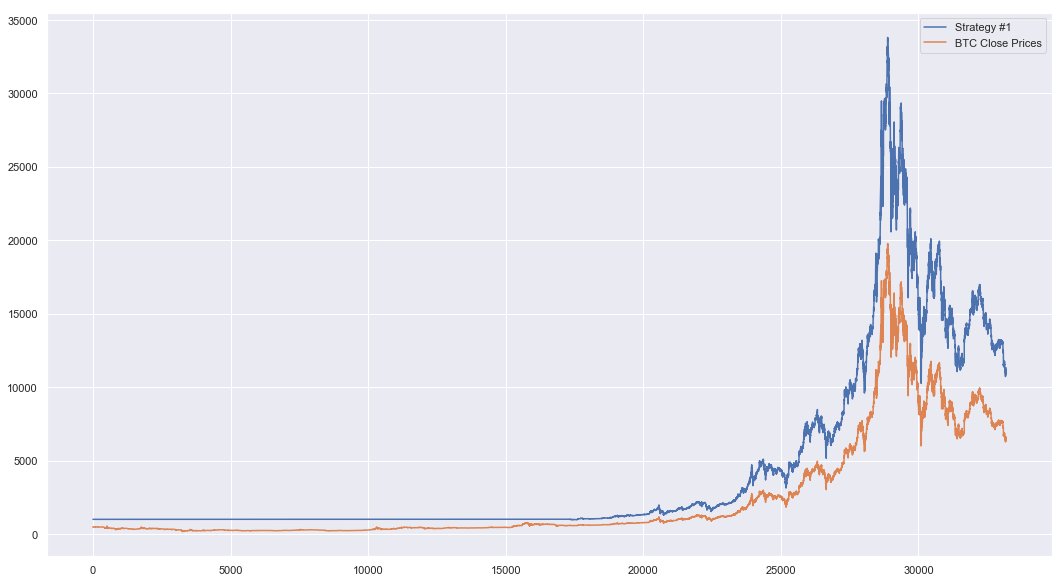

In [18]:
time_window = 1

prices = BTC['close'].values
sentiments = BTC_sentiment['score_en'].values

w = np.zeros(len(prices))
cash = np.zeros(len(prices))

cash[0] = 1000

for i in range(len(prices)-1):
    if sentiments[i] < -2:
        cash[i+1] = w[i]*prices[i] + cash[i]
        w[i+1] = 0
    if sentiments[i] > 2:
        w[i+1] = cash[i]/prices[i]  + w[i]
        cash[i+1] = 0
    else: 
        w[i+1] = w[i]
        cash[i+1] = cash[i]
        
tf_strategy2 = [a*b for a,b in zip(w,prices)]+ cash
plt.plot(tf_strategy2, label = 'Strategy #1')
plt.plot(prices, label = 'BTC Close Prices')
plt.legend()

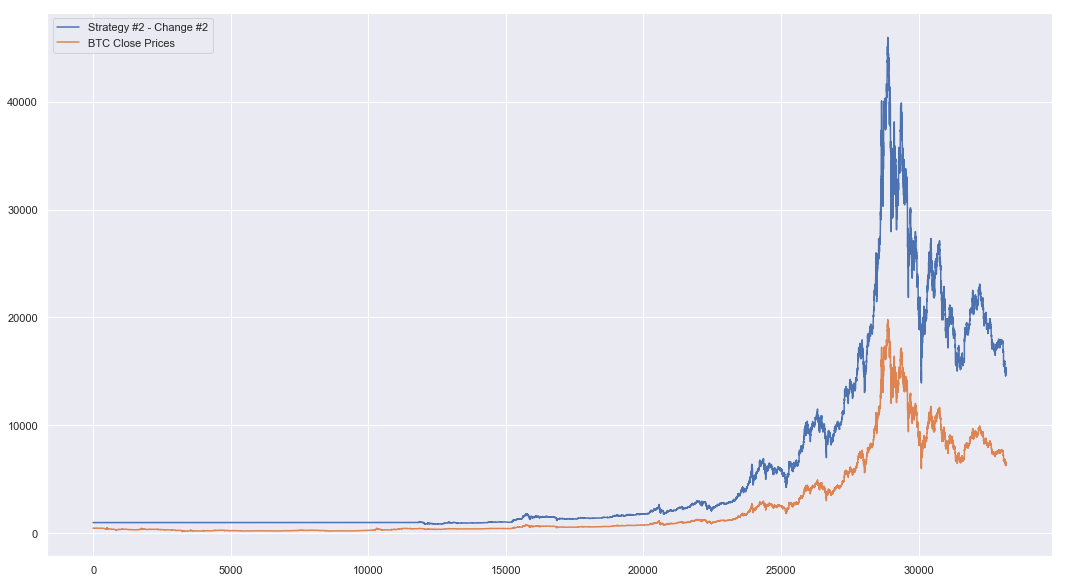

In [19]:
time_window = 1

prices = BTC['close'].values
sentiments = BTC_sentiment['score_en'].values

w = np.zeros(len(prices))
cash = np.zeros(len(prices))

cash[0] = 1000

for i in range(len(prices)-1):
    if sentiments[i] > 2:
        cash[i+1] = w[i]*prices[i] + cash[i]
        w[i+1] = 0
    if sentiments[i] < -2:
        w[i+1] = cash[i]/prices[i]  + w[i]
        cash[i+1] = 0
    else: 
        w[i+1] = w[i]
        cash[i+1] = cash[i]
        
tf_strategy1 = [a*b for a,b in zip(w,prices)]+ cash
plt.plot(tf_strategy1, label = 'Strategy #2 - Change #2')
plt.plot(prices, label = 'BTC Close Prices')
plt.legend()

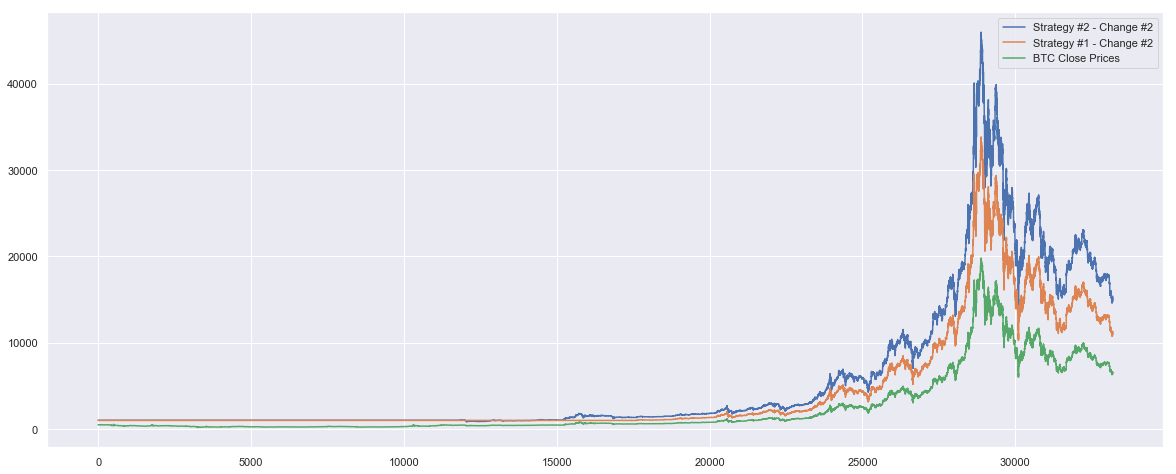

In [22]:
plt.plot(tf_strategy1, label = 'Strategy #2 - Change #2')
plt.plot(tf_strategy2, label = 'Strategy #1 - Change #2')
plt.plot(prices, label = 'BTC Close Prices')
plt.legend()